<a href="https://colab.research.google.com/github/aarchi-dot/deep-learning/blob/main/DL_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement 1: Architecture Design Focus

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

save_path = "/content/drive/MyDrive/cnn_models"
os.makedirs(save_path, exist_ok=True)

print("Models will be saved to:", save_path)


Models will be saved to: /content/drive/MyDrive/cnn_models


PROBLEM STATEMENT 2
# Imbalanced Dataset Handling

In [3]:
!pip install kagglehub imbalanced-learn umap-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

import kagglehub


In [4]:
# Chest X-Ray Dataset
chest_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Flowers Dataset
flower_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Chest Dataset:", chest_path)
print("Flower Dataset:", flower_path)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.


100%|██████████| 225M/225M [00:01<00:00, 136MB/s]

Extracting files...


Chest Dataset: /kaggle/input/chest-xray-pneumonia
Flower Dataset: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [6]:
flower_train = datasets.ImageFolder(
    root=f"{flower_path}/flowers",
    transform=train_transform
)

flower_loader = DataLoader(flower_train, batch_size=32, shuffle=True)

print("Flower Classes:", flower_train.classes)


Flower Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
chest_train = datasets.ImageFolder(
    root=f"{chest_path}/chest_xray/train",
    transform=train_transform
)

chest_val = datasets.ImageFolder(
    root=f"{chest_path}/chest_xray/val",
    transform=test_transform
)

chest_test = datasets.ImageFolder(
    root=f"{chest_path}/chest_xray/test",
    transform=test_transform
)

print("Chest Classes:", chest_train.classes)


Chest Classes: ['NORMAL', 'PNEUMONIA']


SECTION B – DATA LEVEL TECHNIQUES

In [8]:
def create_weighted_sampler(dataset):
    targets = [label for _, label in dataset]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

flower_sampler = create_weighted_sampler(flower_train)
chest_sampler = create_weighted_sampler(chest_train)

flower_loader_os = DataLoader(flower_train, batch_size=32, sampler=flower_sampler)
chest_loader_os = DataLoader(chest_train, batch_size=32, sampler=chest_sampler)


In [9]:
def undersample_dataset(dataset):
    targets = np.array([label for _, label in dataset])
    min_count = min(np.bincount(targets))
    indices = []

    for cls in np.unique(targets):
        cls_idx = np.where(targets == cls)[0]
        np.random.shuffle(cls_idx)
        indices.extend(cls_idx[:min_count])

    return torch.utils.data.Subset(dataset, indices)

flower_under = undersample_dataset(flower_train)
chest_under = undersample_dataset(chest_train)

flower_loader_us = DataLoader(flower_under, batch_size=32, shuffle=True)
chest_loader_us = DataLoader(chest_under, batch_size=32, shuffle=True)


In [10]:
def apply_smote(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, target in loader:
            images = images.cuda() if torch.cuda.is_available() else images
            feat = model.features(images)
            feat = torch.flatten(feat, 1)
            features.append(feat.cpu().numpy())
            labels.append(target.numpy())

    X = np.vstack(features)
    y = np.hstack(labels)

    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)

    return X_res, y_res


ALGORITHM LEVEL TECHNIQUES

In [11]:
def get_class_weights(dataset):
    targets = [label for _, label in dataset]
    counts = np.bincount(targets)
    weights = 1.0 / torch.tensor(counts, dtype=torch.float)
    return weights

flower_weights = get_class_weights(flower_train)
chest_weights = get_class_weights(chest_train)

criterion_flower_weighted = nn.CrossEntropyLoss(weight=flower_weights)
criterion_chest_weighted = nn.CrossEntropyLoss(weight=chest_weights)


In [12]:
class CostSensitiveLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.weights = class_weights

    def forward(self, outputs, targets):
        ce = nn.CrossEntropyLoss(reduction='none')(outputs, targets)
        weighted = ce * self.weights[targets]
        return weighted.mean()


In [13]:
def evaluate_with_threshold(model, loader, threshold=0.4):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda() if torch.cuda.is_available() else images
            outputs = torch.softmax(model(images), dim=1)
            preds = (outputs[:,1] > threshold).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return classification_report(all_labels, all_preds)


EVALUATION

In [14]:
def evaluate_model(model, loader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for images, target in loader:
            images = images.cuda() if torch.cuda.is_available() else images
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(target.numpy())

    print(classification_report(labels, preds))
    print("Balanced Accuracy:", balanced_accuracy_score(labels, preds))
    print("Macro F1:", f1_score(labels, preds, average='macro'))


In [15]:
!pip install torchmetrics thop -q

import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import classification_report
from torchmetrics.functional import accuracy
from thop import profile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [16]:
import torchvision.models as models

def get_resnet(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_efficientnet(num_classes):
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.to(device)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}")

    return train_losses


In [18]:
def evaluate_model(model, loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    # Accuracy
    acc = np.mean(np.array(all_preds) == np.array(all_labels))

    # Top-3 Accuracy (for flowers)
    if num_classes > 2:
        top3 = accuracy(torch.tensor(all_probs),
                        torch.tensor(all_labels),
                        task="multiclass",
                        num_classes=num_classes,
                        top_k=3)
    else:
        top3 = None

    # F1 and Precision/Recall
    report = classification_report(all_labels, all_preds, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    return acc, top3, macro_f1, balanced_acc, cm, all_probs, all_labels


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes_flower = len(flower_train.classes)

resnet_flower = get_resnet(num_classes_flower)
efficient_flower = get_efficientnet(num_classes_flower)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_flower.parameters(), lr=0.001)
optimizer_eff = optim.Adam(efficient_flower.parameters(), lr=0.001)

print("Training ResNet on Flowers")
train_model(resnet_flower, flower_loader_os, flower_loader_os, criterion, optimizer_resnet)

print("Training EfficientNet on Flowers")
train_model(efficient_flower, flower_loader_os, flower_loader_os, criterion, optimizer_eff)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 136MB/s]


Training ResNet on Flowers
Epoch [1/5], Loss: 0.6722
Epoch [2/5], Loss: 0.4964
Epoch [3/5], Loss: 0.4067
Epoch [4/5], Loss: 0.3484
Epoch [5/5], Loss: 0.3116
Training EfficientNet on Flowers
Epoch [1/5], Loss: 0.4390
Epoch [2/5], Loss: 0.2398
Epoch [3/5], Loss: 0.2172
Epoch [4/5], Loss: 0.1781
Epoch [5/5], Loss: 0.1597


[0.4390007338038197,
 0.23982654048336877,
 0.21716798877826443,
 0.1781011524023833,
 0.1596528406565388]

In [21]:
torch.save(efficient_flower.state_dict(),
           f"{save_path}/efficientnet_flower.pth")

torch.save(resnet_flower.state_dict(),
           f"{save_path}/resnet_flower.pth")

print("Models saved successfully!")


Models saved successfully!


In [22]:
num_classes_chest = len(chest_train.classes)

resnet_chest = get_resnet(num_classes_chest)
efficient_chest = get_efficientnet(num_classes_chest)

criterion = nn.CrossEntropyLoss()

optimizer_resnet = optim.Adam(resnet_chest.parameters(), lr=0.001)
optimizer_eff = optim.Adam(efficient_chest.parameters(), lr=0.001)

print("Training ResNet on Chest")
train_model(resnet_chest, chest_loader_os, chest_loader_os, criterion, optimizer_resnet)

print("Training EfficientNet on Chest")
train_model(efficient_chest, chest_loader_os, chest_loader_os, criterion, optimizer_eff)


Training ResNet on Chest
Epoch [1/5], Loss: 0.1493
Epoch [2/5], Loss: 0.0845
Epoch [3/5], Loss: 0.0797
Epoch [4/5], Loss: 0.0646
Epoch [5/5], Loss: 0.0668
Training EfficientNet on Chest
Epoch [1/5], Loss: 0.1440
Epoch [2/5], Loss: 0.0695
Epoch [3/5], Loss: 0.0591
Epoch [4/5], Loss: 0.0426
Epoch [5/5], Loss: 0.0498


[0.1439617920918333,
 0.06954269916207695,
 0.05907659520369389,
 0.0425636335551036,
 0.04978617959528336]

In [23]:
torch.save(efficient_chest.state_dict(),
           f"{save_path}/efficientnet_chest.pth")

torch.save(resnet_chest.state_dict(),
           f"{save_path}/resnet_chest.pth")

print("Models saved successfully!")


Models saved successfully!


# flower

In [24]:
acc_r, top3_r, f1_r, bal_r, cm_r, probs_r, labels_r = evaluate_model(
    resnet_flower, flower_loader, num_classes_flower)

acc_e, top3_e, f1_e, bal_e, cm_e, probs_e, labels_e = evaluate_model(
    efficient_flower, flower_loader, num_classes_flower)

print("ResNet Flower Accuracy:", acc_r)
print("EfficientNet Flower Accuracy:", acc_e)


/tmp/ipython-input-1306553613.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  top3 = accuracy(torch.tensor(all_probs),


ResNet Flower Accuracy: 0.87607134584202
EfficientNet Flower Accuracy: 0.9722029186935371


In [26]:
from torchmetrics.functional import accuracy

def compute_topk_accuracy(probs, labels, k=3):
    probs = torch.tensor(probs)
    labels = torch.tensor(labels)

    return accuracy(
        probs,
        labels,
        task="multiclass",
        num_classes=probs.shape[1],
        top_k=k
    ).item()

top3_resnet = compute_topk_accuracy(probs_r, labels_r, k=3)
print("ResNet Top-3 Accuracy:", top3_resnet)


ResNet Top-3 Accuracy: 0.9865647554397583


In [27]:
from sklearn.metrics import classification_report

def print_class_metrics(labels, preds, class_names):
    report = classification_report(labels, preds, target_names=class_names)
    print(report)


In [28]:
print_class_metrics(labels_r, np.argmax(probs_r, axis=1), flower_train.classes)


              precision    recall  f1-score   support

       daisy       0.89      0.93      0.91       764
   dandelion       0.92      0.90      0.91      1052
        rose       0.91      0.72      0.80       784
   sunflower       0.97      0.89      0.93       733
       tulip       0.75      0.93      0.83       984

    accuracy                           0.88      4317
   macro avg       0.89      0.87      0.88      4317
weighted avg       0.89      0.88      0.88      4317



In [30]:
from sklearn.metrics import precision_recall_curve, auc

probs_chest = np.array(probs_r)
labels_chest = np.array(labels_r)

precision, recall, _ = precision_recall_curve(labels_chest, probs_chest[:,1])
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.title(f"PR Curve (AUC={pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


ValueError: multiclass format is not supported

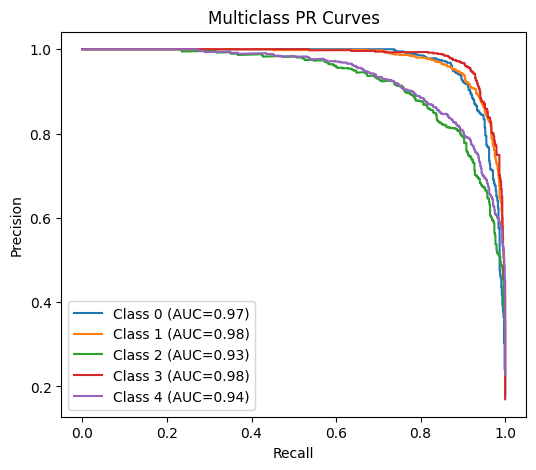

In [31]:
from sklearn.preprocessing import label_binarize

probs_r = np.array(probs_r)
labels_r = np.array(labels_r)

num_classes = probs_r.shape[1]
labels_bin = label_binarize(labels_r, classes=range(num_classes))

plt.figure(figsize=(6,5))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(labels_bin[:, i], probs_r[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass PR Curves")
plt.legend()
plt.show()


In [32]:
def measure_inference_time(model, loader):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            model(images)

    end = time.time()
    return (end - start) / len(loader)

time_resnet = measure_inference_time(resnet_flower, flower_loader)
time_eff = measure_inference_time(efficient_flower, flower_loader)

print("ResNet Inference Time per batch:", time_resnet)
print("EfficientNet Inference Time per batch:", time_eff)


ResNet Inference Time per batch: 0.20795685980055068
EfficientNet Inference Time per batch: 0.1896002486900047


In [33]:
def compute_gmean(cm):
    sensitivities = []
    for i in range(len(cm)):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        sensitivity = tp / (tp + fn + 1e-8)
        sensitivities.append(sensitivity)

    gmean = np.prod(sensitivities) ** (1/len(sensitivities))
    return gmean

gmean_resnet = compute_gmean(cm_r)
print("ResNet G-Mean:", gmean_resnet)


ResNet G-Mean: 0.8678895810110853


In [34]:
def model_complexity(model):
    dummy = torch.randn(1,3,224,224).to(device)
    flops, params = profile(model.to(device), inputs=(dummy,))
    return flops, params

flops_r, params_r = model_complexity(resnet_flower)
flops_e, params_e = model_complexity(efficient_flower)

comparison_complexity = pd.DataFrame({
    "Model": ["ResNet", "EfficientNet"],
    "FLOPs": [flops_r, flops_e],
    "Parameters": [params_r, params_e],
    "Inference Time": [time_resnet, time_eff]
})

comparison_complexity


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Regis

,Model,FLOPs,Parameters,Inference Time
0,ResNet,1.823524e+09,11179077.0,0.207957
1,EfficientNet,4.138714e+08,4013953.0,0.189600


In [35]:
comparison_metrics = pd.DataFrame({
    "Model": ["ResNet", "EfficientNet"],
    "Accuracy": [acc_r, acc_e],
    "Macro F1": [f1_r, f1_e],
    "Balanced Accuracy": [bal_r, bal_e],
    "G-Mean": [gmean_resnet, compute_gmean(cm_e)]
})

comparison_metrics


,Model,Accuracy,Macro F1,Balanced Accuracy,G-Mean
0,ResNet,0.876071,0.876811,0.871921,0.867890
1,EfficientNet,0.972203,0.971786,0.970500,0.970265


## **part 4**

In [36]:
# Choose best architecture
num_classes = len(flower_train.classes)

model = get_efficientnet(num_classes)
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat